# Autoencoder

 - Autoencoders consist of two main parts: an encoder and a decoder. 
   - The **encoder** compresses the input into a lower-dimensional latent space representation.
   - The **decoder** reconstructs the output from this latent representation, aiming to match the original input as closely as possible.

In [39]:
! pip install torchsummary  # to print the summary of the model

In [40]:
# Import the libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import utils as utls
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torch.optim as optim


In [55]:
# Load and Preprocess the Data
# Parameters and Run training and testing
batch_size = 250
input_size = 32 #size of input to first convolutional layer

#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load MNIST dataset and convert the images to float tensor 
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((input_size, input_size)),transforms.Normalize((0,), (1,))]), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


<class 'torch.Tensor'>
torch.Size([250, 1, 32, 32])
torch.Size([250])
(32, 32)


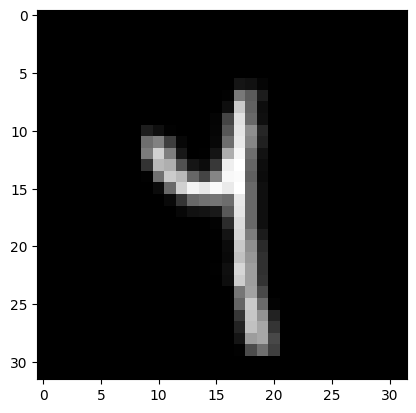

In [42]:
# Visualize the data
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
#Printing the size of one image
print(images[1].numpy().squeeze().shape)

plt.imshow(images[1].numpy().squeeze(), cmap='gray');

# Convolution Autoencoder
   - In this Convolutional Autoencoder, we are using convolutional layers in both encoder and decoder. 
      - **Convolutional enocoder**: The encoder now has three convolutional layers, each followed by a ReLU activation and the first two of them followed by a max pooling layer. The third convolutional layer is added to further compress the data into a more compact latent representation.
      - **Convolutional Decoder**: The decoder uses transposed convolutional layer to gradually upscale the compressed representation back to the original image size

In [43]:
# Define the autoencoder architecture
class conv_Autoencoder(nn.Module):
    def __init__(self):
        super(conv_Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
           nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

# Initialize the autoencoder
conv_model = conv_Autoencoder()


In [44]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
conv_model.to(device)

# Loss function and optimizer
conv_criterion = nn.MSELoss()
conv_optimizer = optim.Adam(conv_model.parameters(), lr=0.001)
print(conv_model)
# summary(conv_model, input_size=(1, input_size, input_size))

Using device: cuda
conv_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


In [45]:
# Train the autoencoder
n_epochs = 30
epoch_losses = []

# Ensure the model is on the right device
conv_model = conv_model.to(device)

start_time = time.time() 

for epoch in range(1, n_epochs+1):
    epoch_start_time = time.time()
    train_loss = 0.0
    for data in train_loader:
        images, _ = data  # images, labels
        images = images.to(device)  # Move images to the same device as the model

        conv_optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs,_ = conv_model(images)
        # calculate the loss
        loss = conv_criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        conv_optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    epoch_losses.append(train_loss)
    epoch_duration = time.time() - epoch_start_time
    print('Epoch: {} \tTraining Loss: {:.6f} \tEpoch Duration: {:.2f} seconds:'.format(epoch, train_loss,epoch_duration))
    
end_time = time.time()  # Record the end time of the training
print(f"Training completed in {end_time - start_time:.2f} seconds.")
# Save the model
torch.save(conv_model.state_dict(), 'conv_autoencoder.pth')

Epoch: 1 	Training Loss: 19.754078 	Epoch Duration: 19.57 seconds:
Epoch: 2 	Training Loss: 2.747820 	Epoch Duration: 19.71 seconds:
Epoch: 3 	Training Loss: 1.256770 	Epoch Duration: 19.53 seconds:
Epoch: 4 	Training Loss: 0.997911 	Epoch Duration: 19.52 seconds:
Epoch: 5 	Training Loss: 0.856625 	Epoch Duration: 19.39 seconds:
Epoch: 6 	Training Loss: 0.770148 	Epoch Duration: 19.42 seconds:
Epoch: 7 	Training Loss: 0.710868 	Epoch Duration: 19.46 seconds:
Epoch: 8 	Training Loss: 0.668972 	Epoch Duration: 19.53 seconds:
Epoch: 9 	Training Loss: 0.638969 	Epoch Duration: 19.46 seconds:
Epoch: 10 	Training Loss: 0.616079 	Epoch Duration: 19.63 seconds:
Epoch: 11 	Training Loss: 0.597439 	Epoch Duration: 19.44 seconds:
Epoch: 12 	Training Loss: 0.581528 	Epoch Duration: 19.35 seconds:
Epoch: 13 	Training Loss: 0.567224 	Epoch Duration: 19.19 seconds:
Epoch: 14 	Training Loss: 0.555028 	Epoch Duration: 19.29 seconds:
Epoch: 15 	Training Loss: 0.545124 	Epoch Duration: 19.26 seconds:
Epo

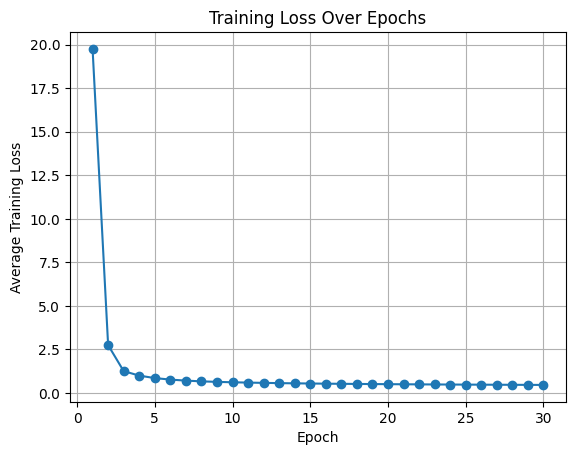

In [48]:
import matplotlib.pyplot as plt

# epoch_losses contains the average loss per epoch
plt.plot(range(1, n_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


In [50]:
# Assuming conv_model, test_loader, device, and conv_criterion are already defined

conv_model.eval()
test_loss = 0
total_inference_time = 0

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        start_time = time.time()
        outputs, _ = conv_model(images)
        inference_time = time.time() - start_time
        total_inference_time += inference_time
        loss = conv_criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

avg_loss = test_loss / len(test_loader.dataset)
avg_inference_time = total_inference_time / len(test_loader)

print(f"Average test loss: {avg_loss:.4f}, Average inference time: {avg_inference_time:.4f}s")


Average test loss: 0.0018, Average inference time: 0.0005s


In [51]:
! pip install torchvision

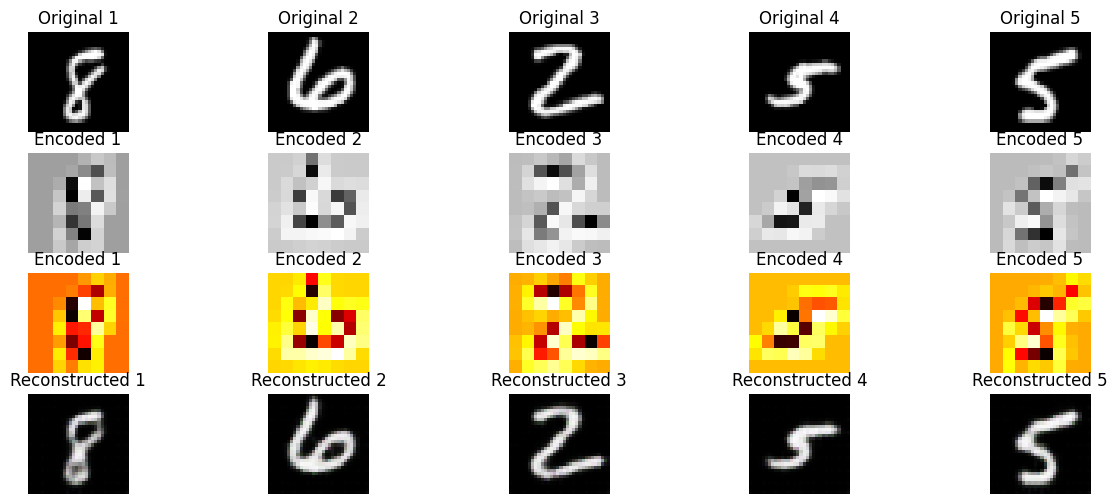

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Get the output from the model
with torch.no_grad():
    conv_model.eval()
    outputs, encoded  = conv_model(images)

# Convert images, encoded, and outputs to CPU for plotting if running on GPU
images = images.cpu()
outputs = outputs.cpu()
encoded = encoded.cpu()  # May need reshaping or processing

# Plot the first few images, their encoded representations, and their reconstructions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,6))  # Adjust the size as needed

for i in range(5):
    # Display original images
    ax = axes[0, i]
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)).squeeze(), cmap='Greys_r')
    ax.set_title(f'Original {i+1}')
    ax.axis('off')

    # Display encoded representations (reshape or process if needed)
    ax = axes[1, i]
    # Example: visualize the first channel of the encoded output
    encoded_img = encoded[i][0].numpy()  # Adjust indexing based on your encoded tensor
    ax.imshow(encoded_img, cmap='Greys_r') # hot
    ax.set_title(f'Encoded {i+1}')
    ax.axis('off')
    
    # Display encoded representations (reshape or process if needed)
    ax = axes[2, i]
    # Example: visualize the first channel of the encoded output
    encoded_img = encoded[i][0].numpy()  # Adjust indexing based on your encoded tensor
    ax.imshow(encoded_img, cmap='hot') # hot
    ax.set_title(f'Encoded {i+1}')
    ax.axis('off')
    
    # Display reconstructed images
    ax = axes[3, i]
    # Transpose the image dimensions
    reconstructed_image = np.transpose(outputs[i].numpy(), (1, 2, 0))
    ax.imshow(reconstructed_image.squeeze(), cmap='Greys_r')
    ax.set_title(f'Reconstructed {i+1}')
    ax.axis('off')


plt.show()



Training with learning rate: 0.01
Epoch: 1 	Training Loss: 5.954851 	Epoch Duration: 19.22 seconds
Epoch: 2 	Training Loss: 0.862399 	Epoch Duration: 19.16 seconds
Epoch: 3 	Training Loss: 0.735114 	Epoch Duration: 19.21 seconds
Epoch: 4 	Training Loss: 0.677288 	Epoch Duration: 19.23 seconds
Epoch: 5 	Training Loss: 0.643802 	Epoch Duration: 19.04 seconds
Epoch: 6 	Training Loss: 0.618352 	Epoch Duration: 19.14 seconds
Epoch: 7 	Training Loss: 0.602755 	Epoch Duration: 19.46 seconds
Epoch: 8 	Training Loss: 0.588855 	Epoch Duration: 19.26 seconds
Epoch: 9 	Training Loss: 0.574946 	Epoch Duration: 19.32 seconds
Epoch: 10 	Training Loss: 0.567045 	Epoch Duration: 19.26 seconds
Epoch: 11 	Training Loss: 0.558403 	Epoch Duration: 19.09 seconds
Epoch: 12 	Training Loss: 0.551163 	Epoch Duration: 19.40 seconds
Epoch: 13 	Training Loss: 0.543134 	Epoch Duration: 19.29 seconds
Epoch: 14 	Training Loss: 0.535859 	Epoch Duration: 19.26 seconds
Epoch: 15 	Training Loss: 0.530442 	Epoch Duration

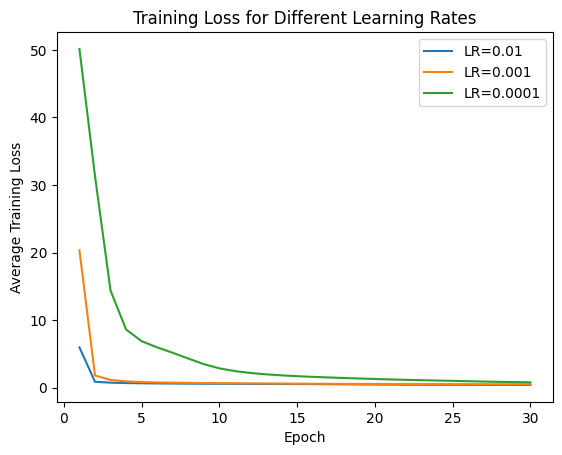

In [56]:
learning_rates = [0.01, 0.001, 0.0001]  # Example learning rates
all_epoch_losses = {}  # Dictionary to store losses for each learning rate

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    conv_model = conv_Autoencoder().to(device)  # Reinitialize the model
    conv_optimizer = optim.Adam(conv_model.parameters(), lr=lr)
    epoch_losses = []

    for epoch in range(1, n_epochs + 1):
        epoch_start_time = time.time()
        train_loss = 0.0

        for data in train_loader:
            images, _ = data
            images = images.to(device)
            conv_optimizer.zero_grad()
            outputs, _ = conv_model(images)
            loss = conv_criterion(outputs, images)
            loss.backward()
            conv_optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader)
        epoch_losses.append(train_loss)
        epoch_duration = time.time() - epoch_start_time
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tEpoch Duration: {epoch_duration:.2f} seconds')

    all_epoch_losses[lr] = epoch_losses

# Plotting the results
for lr, losses in all_epoch_losses.items():
    plt.plot(range(1, n_epochs + 1), losses, label=f'LR={lr}')

plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()
